## TPE Tuning

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from dotenv import load_dotenv
import os

from sklearn.pipeline import Pipeline
from feature_engine.selection import DropConstantFeatures, DropDuplicateFeatures, SelectByShuffling

from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from boruta import BorutaPy
from sklearn.experimental import enable_iterative_imputer
from sklearn.model_selection import train_test_split
from sklearn.impute import IterativeImputer
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import BayesianRidge

from sklearn.tree import DecisionTreeRegressor

import xgboost as xgb
from xgboost import XGBClassifier
from ngboost import NGBClassifier
from ngboost.distns import k_categorical

from sklearn.model_selection import StratifiedKFold, cross_validate, cross_val_score
from sklearn.metrics import accuracy_score, roc_auc_score, recall_score, precision_score, f1_score, balanced_accuracy_score

import optuna

c:\Users\steve\Desktop\Notebooks\Thesis-Project\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Import dataset
load_dotenv()
dataset_path=os.getenv("DATASET_PATH_H")
dataset = pd.read_csv(dataset_path)
dataset.head()

,RID,Gender,Ageatscreening,Diagnosis,MMSE0m,HipsASMbaseline,HipsContrastbaseline,HipsCorelationbaseline,HipsVariancebaseline,HipsSumAveragebaseline,...,ERCsContrastbaseline,ERCsCorelationbaseline,ERCsVariancebaseline,ERCsSumAveragebaseline,ERCsSumVariancebaseline,ERCsEntropybaseline,ERCsClusterShadebaseline,ERCs_thicknessbaseline,ERCsVolumebaseline,HipposcampusVolumebaseline
0,30865,0,73.697464,2,24.0,0.101093,175.393565,0.500722,173.535247,36.096518,...,323.798648,0.299493,221.695882,33.818211,587.066626,2.566872,4933.163606,2.563102,1220.610295,3064.823503
1,56,1,69.739700,0,28.0,0.212798,195.048004,0.548047,213.046946,31.734453,...,195.048004,0.548047,213.046946,31.734453,657.139780,3.031522,5550.425475,3.575500,1631.500000,3787.600000
2,30954,0,80.068440,2,17.0,0.143582,170.267530,0.545575,186.379698,36.728908,...,293.749080,0.414145,236.239837,32.057643,657.793732,2.890965,2170.192290,2.327126,791.995138,1978.973986
3,30236,1,69.656400,0,29.0,0.091508,181.028196,0.513832,184.033694,36.926329,...,204.766567,0.544235,226.620772,28.370820,695.606291,2.959220,-764.206140,3.064959,1750.726546,2795.938756
4,999,0,70.939700,2,25.0,0.148471,186.692642,0.611493,238.617863,36.628890,...,243.453948,0.468833,229.417825,28.994963,674.217352,2.885460,-1323.069060,2.545500,1191.500000,2914.950000


In [3]:
# Split by subject
subjects = dataset['RID'].unique()
first_diag_per_subject = dataset.groupby('RID')['Diagnosis'].first()

train_subs, test_subs = train_test_split(
    subjects,
    test_size=0.3,
    random_state=42,
    stratify=first_diag_per_subject
)

# Assign rows
train_df = dataset[dataset['RID'].isin(train_subs)].copy()
test_df  = dataset[dataset['RID'].isin(test_subs)].copy()

# Separate X and y
y_train = train_df['Diagnosis']
y_test  = test_df['Diagnosis']
X_train = train_df.drop(columns=['Diagnosis'])
X_test  = test_df.drop(columns=['Diagnosis'])

# -----------------------------
# Check for subject-level overlap
# -----------------------------
overlap_subjects = set(train_df['RID']).intersection(set(test_df['RID']))
if len(overlap_subjects) == 0:
    print("No subjects appear in both train and test sets.")
else:
    print(f"Overlapping subjects found: {overlap_subjects}")

print(f"Number of subjects in train: {len(train_df['RID'].unique())}")
print(f"Number of subjects in test: {len(test_df['RID'].unique())}")


No subjects appear in both train and test sets.
Number of subjects in train: 778
Number of subjects in test: 334


In [4]:
imputer_knn = IterativeImputer(
    estimator=DecisionTreeRegressor(),
    random_state=42,
)

imputer_knn.fit(X_train)
X_train_knn = imputer_knn.transform(X_train)
X_test_knn = imputer_knn.transform(X_test)

In [5]:
X_train_knn_t = pd.DataFrame(
    X_train_knn, 
    columns=X_train.columns, 
    index=X_train.index  # Critical fix
)
X_test_knn_t = pd.DataFrame(
    X_test_knn, 
    columns=X_test.columns, 
    index=X_test.index  # Critical fix
)

In [6]:
pipe = Pipeline([
    ('constant', DropConstantFeatures(tol=1, variables=None, missing_values='raise')),
    ('quasi-constant', DropConstantFeatures(tol=0.998, variables=None, missing_values='raise')),
    ('duplicated', DropDuplicateFeatures()),
])

pipe.fit(X_train_knn_t)

Pipeline(steps=[('constant', DropConstantFeatures()),
                ('quasi-constant', DropConstantFeatures(tol=0.998)),
                ('duplicated', DropDuplicateFeatures())])

In [7]:
X_train_t = pipe.transform(X_train_knn_t)
X_test_t = pipe.transform(X_test_knn_t)

X_train_t.shape, X_test_t.shape

((778, 23), (335, 23))

In [8]:
sel = ['RID', 'Ageatscreening', 'MMSE0m', 'HipsEntropybaseline',
       'HipsClusterShadebaseline', 'ERCsContrastbaseline',
       'ERCsCorelationbaseline', 'ERCs_thicknessbaseline',
       'ERCsVolumebaseline', 'HipposcampusVolumebaseline']

In [9]:
selected_features = [col for col in sel if col in X_train_t.columns]
selected_features

['RID',
 'Ageatscreening',
 'MMSE0m',
 'HipsEntropybaseline',
 'HipsClusterShadebaseline',
 'ERCsContrastbaseline',
 'ERCsCorelationbaseline',
 'ERCs_thicknessbaseline',
 'ERCsVolumebaseline',
 'HipposcampusVolumebaseline']

In [10]:
# Transform training and test sets using selected features
X_train_t = X_train_t[selected_features]
X_test_t = X_test_t[selected_features]

X_train_t.shape, X_test_t.shape

((778, 10), (335, 10))

## TPE

In [11]:
def objective(trial):
        
    skf = StratifiedKFold(n_splits=10,
                             shuffle=True,
                             random_state=42,
        )
    
    # Base learner (for NGBoost)
    learner = DecisionTreeRegressor(
        max_depth=trial.suggest_int("ngb_base_max_depth", 3, 6),
        criterion=trial.suggest_categorical("ngb_base_criterion", ['squared_error', 'friedman_mse']),
        min_samples_leaf=trial.suggest_float("ngb_base_min_samples_leaf", 0.005, 0.05),
        random_state=42
    )
    
    ngb_n_estimators = trial.suggest_int("ngb_n_estimators", 100, 500)
    ngb_learning_rate = trial.suggest_float("ngb_learning_rate", 0.005, 0.2, log=True)    
    model = NGBClassifier(Dist=k_categorical(len(np.unique(y_train))),
                          Base=learner,
                          n_estimators=ngb_n_estimators,
                          learning_rate=ngb_learning_rate,
                          natural_gradient=True,
                          verbose=False) 

    score = cross_val_score(model, X_train_t, y_train, scoring="balanced_accuracy", cv=skf)
    
    accuracy = score.mean()
    
    return accuracy

In [12]:
study = optuna.create_study(
    direction="maximize",
    sampler=optuna.samplers.TPESampler(),
)

study.optimize(objective, n_trials=20)

[I 2025-11-13 22:33:24,715] A new study created in memory with name: no-name-78a7d31e-0a63-4c6d-9c2b-e4390cefe12d


[I 2025-11-13 22:34:52,101] Trial 0 finished with value: 0.7059095860566449 and parameters: {'ngb_base_max_depth': 3, 'ngb_base_criterion': 'squared_error', 'ngb_base_min_samples_leaf': 0.04577315967936354, 'ngb_n_estimators': 462, 'ngb_learning_rate': 0.013307826889684363}. Best is trial 0 with value: 0.7059095860566449.
[I 2025-11-13 22:35:16,889] Trial 1 finished with value: 0.687755991285403 and parameters: {'ngb_base_max_depth': 4, 'ngb_base_criterion': 'friedman_mse', 'ngb_base_min_samples_leaf': 0.014494144294031137, 'ngb_n_estimators': 119, 'ngb_learning_rate': 0.013950015339766772}. Best is trial 0 with value: 0.7059095860566449.
[I 2025-11-13 22:37:09,055] Trial 2 finished with value: 0.7041938997821351 and parameters: {'ngb_base_max_depth': 5, 'ngb_base_criterion': 'squared_error', 'ngb_base_min_samples_leaf': 0.006147685501857809, 'ngb_n_estimators': 435, 'ngb_learning_rate': 0.026174843378124625}. Best is trial 0 with value: 0.7059095860566449.
[I 2025-11-13 22:38:03,620] 

In [13]:
study.best_params

{'ngb_base_max_depth': 3,
 'ngb_base_criterion': 'squared_error',
 'ngb_base_min_samples_leaf': 0.04688264099685057,
 'ngb_n_estimators': 499,
 'ngb_learning_rate': 0.010959922902412501}

In [14]:
study.best_value

0.7087336601307189

In [15]:
r = study.trials_dataframe()

r.head()

,number,value,datetime_start,datetime_complete,duration,params_ngb_base_criterion,params_ngb_base_max_depth,params_ngb_base_min_samples_leaf,params_ngb_learning_rate,params_ngb_n_estimators,state
0,0,0.705910,2025-11-13 22:33:24.719958,2025-11-13 22:34:52.101529,0 days 00:01:27.381571,squared_error,3,0.045773,0.013308,462,COMPLETE
1,1,0.687756,2025-11-13 22:34:52.102529,2025-11-13 22:35:16.888516,0 days 00:00:24.785987,friedman_mse,4,0.014494,0.013950,119,COMPLETE
2,2,0.704194,2025-11-13 22:35:16.890609,2025-11-13 22:37:09.054594,0 days 00:01:52.163985,squared_error,5,0.006148,0.026175,435,COMPLETE
3,3,0.699025,2025-11-13 22:37:09.056593,2025-11-13 22:38:03.620250,0 days 00:00:54.563657,squared_error,5,0.035436,0.005556,302,COMPLETE
4,4,0.698423,2025-11-13 22:38:03.621248,2025-11-13 22:38:42.663446,0 days 00:00:39.042198,friedman_mse,4,0.018718,0.020844,189,COMPLETE


C:\Users\steve\AppData\Local\Temp\ipykernel_16876\2278197192.py:1: ExperimentalWarning: plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.
  fig = optuna.visualization.matplotlib.plot_optimization_history(study)


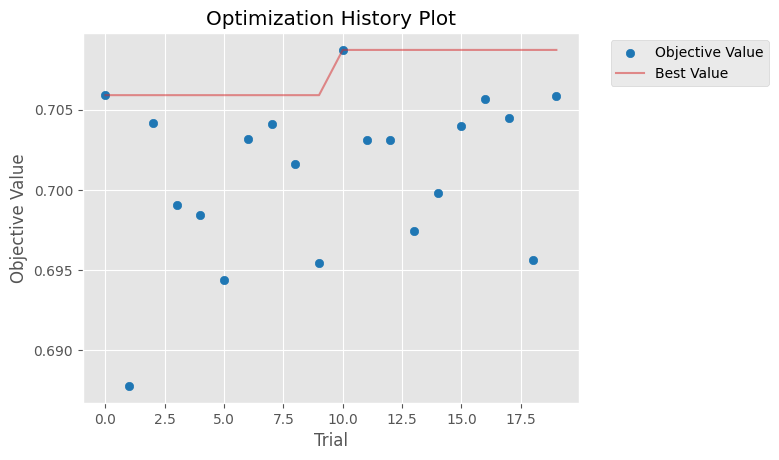

In [16]:
fig = optuna.visualization.matplotlib.plot_optimization_history(study)

C:\Users\steve\AppData\Local\Temp\ipykernel_16876\2652712915.py:1: ExperimentalWarning: plot_slice is experimental (supported from v2.2.0). The interface can change in the future.
  optuna.visualization.matplotlib.plot_slice(


array([<Axes: xlabel='ngb_base_criterion', ylabel='Objective Value'>,
       <Axes: xlabel='ngb_base_max_depth'>,
       <Axes: xlabel='ngb_base_min_samples_leaf'>,
       <Axes: xlabel='ngb_learning_rate'>,
       <Axes: xlabel='ngb_n_estimators'>], dtype=object)

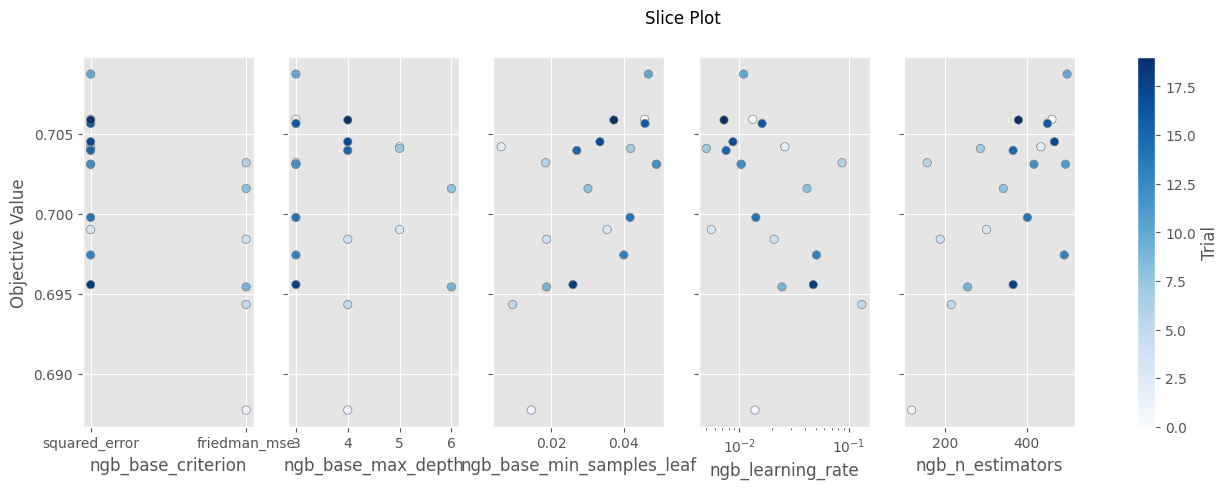

In [17]:
optuna.visualization.matplotlib.plot_slice(
    study,
    params=[
        "ngb_n_estimators",
        "ngb_learning_rate",
        "ngb_base_max_depth",
        "ngb_base_criterion",
        "ngb_base_min_samples_leaf"
    ],
)


C:\Users\steve\AppData\Local\Temp\ipykernel_16876\1036994904.py:1: ExperimentalWarning: plot_param_importances is experimental (supported from v2.2.0). The interface can change in the future.
  optuna.visualization.matplotlib.plot_param_importances(study)


<Axes: title={'left': 'Hyperparameter Importances'}, xlabel='Hyperparameter Importance', ylabel='Hyperparameter'>

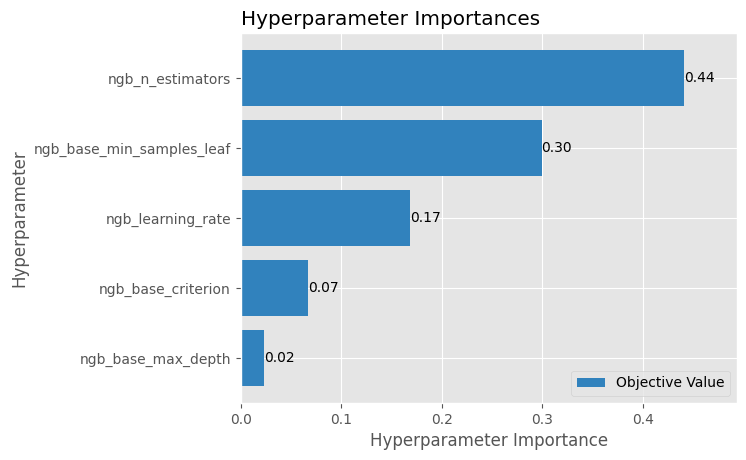

In [18]:
optuna.visualization.matplotlib.plot_param_importances(study)

C:\Users\steve\AppData\Local\Temp\ipykernel_16876\1937692550.py:1: ExperimentalWarning: plot_edf is experimental (supported from v2.2.0). The interface can change in the future.
  optuna.visualization.matplotlib.plot_edf([study])


<Axes: title={'center': 'Empirical Distribution Function Plot'}, xlabel='Objective Value', ylabel='Cumulative Probability'>

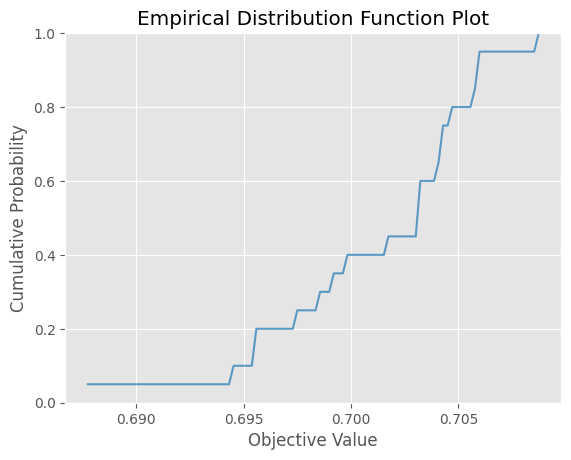

In [19]:
optuna.visualization.matplotlib.plot_edf([study])


### Classification

In [20]:
def run_model(classifier_name, sel_method, X_train, y_train):
        
        # Recreate the best base learner from the study
        base_learner = DecisionTreeRegressor(
                max_depth=study.best_params["ngb_base_max_depth"],
                criterion=study.best_params["ngb_base_criterion"],
                min_samples_leaf=study.best_params["ngb_base_min_samples_leaf"],
                random_state=42
        )
        
        model = NGBClassifier(Dist=k_categorical(len(np.unique(y_train))),
                              Base=base_learner,
                              n_estimators=study.best_params['ngb_n_estimators'],
                              learning_rate=study.best_params['ngb_learning_rate'], 
                              random_state=42
        )

        if sel_method == "Boruta":
                sel_method = "Boruta" 
        else: 
                sel_method = "Complete"
        
        skf = StratifiedKFold(n_splits=10,
                             shuffle=True,
                             random_state=42,
        )
        
        cross_val_results = cross_validate(model,
                                           X_train,
                                           y_train,
                                           cv=skf,
                                           scoring="balanced_accuracy",
                                           return_train_score=True,
        )
               
        # Calculate the metrics for training and testing
        mean_train = [round(np.mean(cross_val_results["train_score"]), 3)]
        std_train = [round(np.std(cross_val_results["train_score"]), 3)]
        mean_test = [round(np.mean(cross_val_results["test_score"]), 3)]
        std_test = [round(np.std(cross_val_results["test_score"]), 3)]
        time = round(np.mean(cross_val_results["fit_time"]), 3)
                
        cv_metrics_df = pd.DataFrame({
                "Feature Selection": sel_method,
                "Classifier": classifier_name,
                "Fit Time": time,
                "Total Features": len(X_train.columns),
                "Metric": "balanced_accuracy",
                "Mean Train": mean_train,
                "Std Train": std_train,
                "Mean Test": mean_test,
                "Std Test": std_test,
        })
        
        fit_model = model.fit(X_train, y_train)
        
        return fit_model, cv_metrics_df


In [21]:
trained_ngb_n, metrics_ngb_n = run_model("NGBoost", "Complete", X_train_knn_t, y_train)
trained_ngb_t, metrics_ngb_t = run_model("NGBoost", "Boruta", X_train_t, y_train)

[iter 0] loss=0.9726 val_loss=0.0000 scale=2.0000 norm=6.8284
[iter 100] loss=0.4228 val_loss=0.0000 scale=1.0000 norm=2.1948
[iter 200] loss=0.3755 val_loss=0.0000 scale=1.0000 norm=2.1566
[iter 300] loss=0.3547 val_loss=0.0000 scale=1.0000 norm=2.1325
[iter 400] loss=0.3442 val_loss=0.0000 scale=0.1250 norm=0.2653
[iter 0] loss=0.9726 val_loss=0.0000 scale=2.0000 norm=6.8284
[iter 100] loss=0.4458 val_loss=0.0000 scale=2.0000 norm=4.4460
[iter 200] loss=0.4006 val_loss=0.0000 scale=2.0000 norm=4.4057
[iter 300] loss=0.3829 val_loss=0.0000 scale=1.0000 norm=2.1967
[iter 400] loss=0.3769 val_loss=0.0000 scale=0.0001 norm=0.0001
[iter 0] loss=0.9726 val_loss=0.0000 scale=2.0000 norm=6.8284
[iter 100] loss=0.4718 val_loss=0.0000 scale=2.0000 norm=4.6128
[iter 200] loss=0.4257 val_loss=0.0000 scale=1.0000 norm=2.2654
[iter 300] loss=0.4049 val_loss=0.0000 scale=0.5000 norm=1.1157
[iter 400] loss=0.3920 val_loss=0.0000 scale=0.5000 norm=1.1050
[iter 0] loss=0.9726 val_loss=0.0000 scale=2.0

In [22]:
validation_df = pd.concat([metrics_ngb_n, metrics_ngb_t])
validation_df_report = validation_df.set_index(["Classifier", "Metric", "Feature Selection", "Fit Time", "Total Features"])
validation_df_report

Mean Train  \
Classifier Metric            Feature Selection Fit Time Total Features               
NGBoost    balanced_accuracy Complete          10.826   23                   0.764   
                             Boruta            7.174    10                   0.752   

                                                                        Std Train  \
Classifier Metric            Feature Selection Fit Time Total Features              
NGBoost    balanced_accuracy Complete          10.826   23                  0.009   
                             Boruta            7.174    10                  0.013   

                                                                        Mean Test  \
Classifier Metric            Feature Selection Fit Time Total Features              
NGBoost    balanced_accuracy Complete          10.826   23                  0.697   
                             Boruta            7.174    10                  0.709   

                                                                        Std Test  
Classifier Metric            Feature Selection Fit Time Total Features            
NGBoost    balanced_accuracy Complete          10.826   23                 0.059  
                             Boruta            7.174    10                 0.050

In [23]:
from sklearn.utils import resample

def bootstrap_ci(model, X, y, metric_fn, n_iterations, ci=0.95, use_proba=False):
    scores = []
    n = len(X)
    for _ in range(n_iterations):
        X_resampled, y_resampled = resample(X, y, n_samples=n, stratify=y)
        try:
            y_pred = model.predict_proba(X_resampled) if use_proba else model.predict(X_resampled)
            score = metric_fn(y_resampled, y_pred)
            if not np.isnan(score):
                scores.append(score)
        except Exception:
            # Skip this bootstrap sample if error occurs (e.g. missing class for roc_auc)
            continue
    if len(scores) == 0:
        return (np.nan, np.nan)
    lower = np.percentile(scores, (1 - ci) / 2 * 100)
    upper = np.percentile(scores, (1 + ci) / 2 * 100)
    std_dev = np.std(scores)
    return round(lower, 3), round(upper, 3), round(std_dev, 3)

In [24]:
from sklearn.metrics import confusion_matrix

def compute_specificity(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    total = cm.sum()
    tp = np.diag(cm)
    fp = cm.sum(axis=0) - tp
    fn = cm.sum(axis=1) - tp
    tn = total - (tp + fp + fn)
    specificity = tn / (tn + fp)
    return round(np.nanmean(specificity), 3)

In [25]:
import time

def eval_model(classifier_name, model, X_train, X_test, y_train, y_test):
        
        if isinstance(X_train, np.ndarray):
                columns = X_train.shape[1]
        else:
                columns = len(X_train.columns)        
        
        start_time = time.time()
        # Get predicted probabilities for ROC AUC
        pred_train_proba = model.predict_proba(X_train)
        pred_test_proba = model.predict_proba(X_test)
        
        # Get predicted accuracy values
        pred_train = model.predict(X_train)
        pred_test = model.predict(X_test)
        
        # Calculate metrics
        # Calculate metrics
        metrics_train = {
                "accuracy": accuracy_score(y_train, pred_train),
                "balanced_accuracy": balanced_accuracy_score(y_train, pred_train),
                "precision_macro": precision_score(y_train, pred_train, average="macro", zero_division=0),
                "recall_macro": recall_score(y_train, pred_train, average="macro", zero_division=0),
                "f1_macro": f1_score(y_train, pred_train, average="macro", zero_division=0),
                "roc_auc_macro": roc_auc_score(y_train, pred_train_proba, average="macro", multi_class="ovr"),
                "specificity_macro": compute_specificity(y_train, pred_train),
        }

        metrics_test = {
                "accuracy": accuracy_score(y_test, pred_test),
                "balanced_accuracy": balanced_accuracy_score(y_test, pred_test),
                "precision_macro": precision_score(y_test, pred_test, average="macro", zero_division=0),
                "recall_macro": recall_score(y_test, pred_test, average="macro", zero_division=0),
                "f1_macro": f1_score(y_test, pred_test, average="macro", zero_division=0),
                "roc_auc_macro": roc_auc_score(y_test, pred_test_proba, average="macro", multi_class="ovr"),
                "specificity_macro": compute_specificity(y_test, pred_test),
        }
                
        elapsed_time = time.time() - start_time
        
        # Metric functions for bootstrap CI (exclude ROC AUC here)
        metric_fns = {
                "accuracy": accuracy_score,
                "balanced_accuracy": balanced_accuracy_score,
                "precision_macro": lambda yt, yp: precision_score(yt, yp, average="macro", zero_division=0),
                "recall_macro": lambda yt, yp: recall_score(yt, yp, average="macro", zero_division=0),
                "f1_macro": lambda yt, yp: f1_score(yt, yp, average="macro", zero_division=0),
                "roc_auc_macro": lambda yt, yp: roc_auc_score(yt, yp, average="macro", multi_class="ovr"),
                "specificity_macro": lambda yt, yp: compute_specificity(yt, yp),
        }

        # Bootstrap confidence intervals
        ci_test = {
                m: bootstrap_ci(
                model, X_test, y_test, fn,
                n_iterations=1000,
                use_proba=(m == "roc_auc_macro")
                )
                for m, fn in metric_fns.items()
        }

        # Separate CI bounds and std with clear variable names
        ci_bounds = []
        std_values = []
                
        for lower, upper, std in ci_test.values():
                ci_bounds.append(f"[{round(lower, 3)}, {round(upper, 3)}]")
                std_values.append(round(std, 3)) 
                
        # Round metric values
        train_rounded = [round(score, 3) for score in metrics_train.values()]
        test_rounded = [round(score, 3) for score in metrics_test.values()] 
    
        # Create the DataFrame without additional rounding
        pred_metrics_df = pd.DataFrame({
                "Feature Selection": "Boruta",
                "Classifier": classifier_name,
                "Classification Time": round(elapsed_time, 3),
                "Total Features": columns,
                "Metric": list(metrics_train.keys()),      
                "Train data": train_rounded,
                "Test data": test_rounded,
                "95% CI": ci_bounds,
                "Std Dev": std_values,
        })
        
        return pred_metrics_df

In [26]:
results = "all"
prediction_df_report = None

if results == "all":

    pred_ngb_n = eval_model("NGBoost", trained_ngb_n, X_train_knn_t, X_test_knn_t, y_train, y_test)
    pred_ngb_t = eval_model("NGBoost", trained_ngb_t, X_train_t, X_test_t, y_train, y_test)
    
    prediction_df = pd.concat([pred_ngb_n, pred_ngb_t])
    prediction_df_report = prediction_df.set_index(["Feature Selection", "Classifier", "Classification Time", "Total Features", "Metric"])
        
elif results == "filtered":

    pred_ngb_t = eval_model("NGBoost", trained_ngb_t, X_train_t, X_test_t, y_train, y_test)
    
    prediction_df = pd.concat([pred_ngb_t])
    prediction_df_report = prediction_df.set_index(["Feature Selection", "Classifier", "Classification Time", "Total Features", "Metric"])

prediction_df_report

Train data  \
Feature Selection Classifier Classification Time Total Features Metric                          
Boruta            NGBoost    2.086               23             accuracy                0.830   
                                                                balanced_accuracy       0.764   
                                                                precision_macro         0.811   
                                                                recall_macro            0.764   
                                                                f1_macro                0.782   
                                                                roc_auc_macro           0.950   
                                                                specificity_macro       0.893   
                             1.310               10             accuracy                0.820   
                                                                balanced_accuracy       0.746   
                                                                precision_macro         0.795   
                                                                recall_macro            0.746   
                                                                f1_macro                0.765   
                                                                roc_auc_macro           0.941   
                                                                specificity_macro       0.887   

                                                                                   Test data  \
Feature Selection Classifier Classification Time Total Features Metric                         
Boruta            NGBoost    2.086               23             accuracy               0.779   
                                                                balanced_accuracy      0.671   
                                                                precision_macro        0.715   
                                                                recall_macro           0.671   
                                                                f1_macro               0.688   
                                                                roc_auc_macro          0.884   
                                                                specificity_macro      0.854   
                             1.310               10             accuracy               0.779   
                                                                balanced_accuracy      0.678   
                                                                precision_macro        0.713   
                                                                recall_macro           0.678   
                                                                f1_macro               0.693   
                                                                roc_auc_macro          0.881   
                                                                specificity_macro      0.857   

                                                                                           95% CI  \
Feature Selection Classifier Classification Time Total Features Metric                              
Boruta            NGBoost    2.086               23             accuracy           [0.743, 0.818]   
                                                                balanced_accuracy  [0.615, 0.725]   
                                                                precision_macro    [0.656, 0.781]   
                                                                recall_macro       [0.613, 0.729]   
                                                                f1_macro            [0.63, 0.742]   
                                                                roc_auc_macro      [0.852, 0.915]   
                                                                specificity_macro  [0.828, 0.881]   
                             1.310               10             accuracy           [

### Export model

In [27]:
trained_ngb_t

NGBClassifier(Base=DecisionTreeRegressor(max_depth=3,
                                         min_samples_leaf=0.04688264099685057,
                                         random_state=42),
              learning_rate=0.010959922902412501, n_estimators=499,
              random_state=RandomState(MT19937) at 0x268AD891D40)

In [28]:
import pickle

# Save the trained model using pickle
with open("ngboost_model.pkl", "wb") as file:
    pickle.dump(trained_ngb_t, file)

print("NGBoost model saved successfully!")

NGBoost model saved successfully!


In [29]:
# Load the saved model using pickle
with open("ngboost_model.pkl", "rb") as file:
    loaded_model_ngb = pickle.load(file)